# Project: Identify Customer Segments

In this project, unsupervised learning techniques will be applied to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data is provided byBertelsmann Arvato Analytics, and represents a real-life data science task.


In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project:

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.


In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data 
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to help you make cleaning decisions during this stage of the project. First of all, assess the demographics data in terms of missing data. And take notes on what I observe. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I'll do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [7]:
# check different values of 'missing_or_unknown' cols of feat_info
feat_info['missing_or_unknown'].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,0,9]     1
[XX]         1
[-1,XX]      1
Name: missing_or_unknown, dtype: int64

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
num = azdias.shape[1]
for col in range(num):
    col_name = azdias.columns[col]
    nlist = feat_info.iloc[col, 3]
    nlist = nlist.replace('[', '').replace(']', '').split(',')
    if nlist==['']:
        continue
    else:
        for na in nlist:
            if azdias[col_name].dtype == 'object':
                azdias.loc[azdias[col_name]==na, col_name]=np.nan
            else:
                azdias.loc[azdias[col_name]==int(na), col_name]=np.nan
                

In [9]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

There are a few columns that are outliers in terms of the proportion of values that are missing. I will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data.

In [10]:
# Perform an assessment of how much missing data there is in each column of the dataset.
azdias_null = azdias.isnull().sum(axis=0)
azdias_null

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

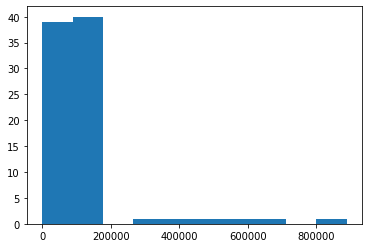

In [11]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(azdias_null);

In [12]:
# number of columns which has null values more than 200000
azdias_null[azdias_null>200000].count()

6

In [13]:
list(azdias_null[azdias_null>200000].index)

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [14]:
# As we can see from the hist above, most columns have null values less than 200000. 
# Therefore, we remove those cols which have null values more than 200000
azdias.drop(columns=list(azdias_null[azdias_null>200000].index), inplace=True)

In [15]:
# check the dataframe
azdias.shape

(891221, 79)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. I will select five of these columns and compare the distribution of values.

If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on.

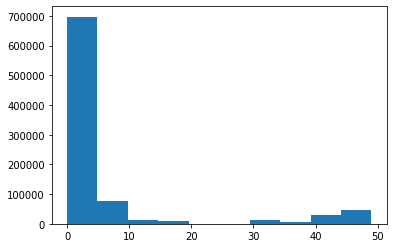

In [16]:
# distribution of missing data in each row
azdias_row_null = azdias.isnull().sum(1)
plt.hist(azdias_row_null);

In [17]:
azdias.loc[azdias_row_null<20, :]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2.0,5.0,1.0,4.0,2.0,5.0,4.0,4.0,1.0,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1.0,4.0,3.0,3.0,3.0,2.0,2.0,3.0,6.0,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2.0,4.0,2.0,4.0,2.0,5.0,4.0,3.0,1.0,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1.0,3.0,1.0,5.0,3.0,5.0,5.0,5.0,1.0,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [18]:
# divide the data into two subsets based on the number of missing values in each row.
# As we can see from the above hist, most rows have missing values fewer than 20
azdias_low = azdias.loc[azdias_row_null<20, :]
azdias_high = azdias.loc[azdias_row_null>20, :]

In [19]:
# check the shapes for both dataframes
print("Row count of the dataframe with fewer row missing values : {}".format(azdias_low.shape[0]))
print("Row count of the dataframe with more row missing values : {}".format(azdias_high.shape[0]))

Row count of the dataframe with fewer row missing values : 797077
Row count of the dataframe with more row missing values : 93795


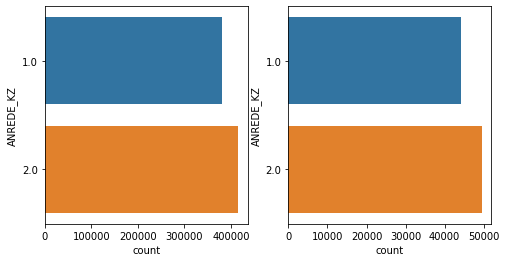

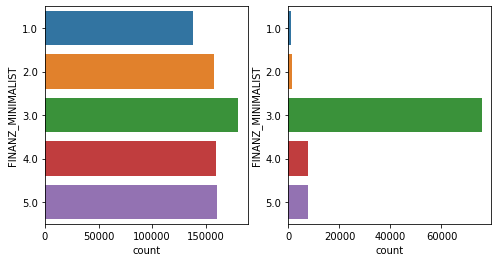

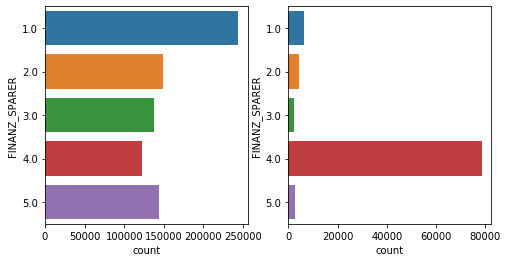

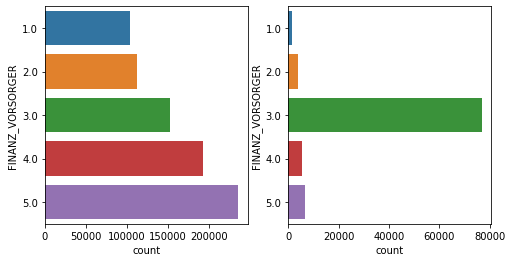

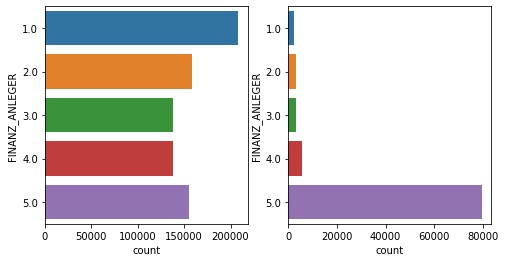

In [20]:
# Compare the disbtribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
col_low = azdias.loc[:, azdias.isnull().mean()==0].columns

for col in range(5):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax1 = fig.add_subplot(121)
    ax1 = sns.countplot(y = col_low[col], data = azdias_low)
    ax2 = fig.add_subplot(122)
    ax2 = sns.countplot(y = col_low[col], data = azdias_high)
    

#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on the comparsion of those five columns, it can be seen from that the two subsets almost contain same values.Futhermore, the subset with fewer missing values only have 93260 rows. Therefore, dropping the subset with more missing values from the analysis won't lead to a major issue.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way to prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether keep, drop, or re-encode each. Then, in the last part, create a new data frame with only the selected and engineered columns.

In [21]:
# Numbers of features of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, i would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform the following:
- For binary (two-level) categoricals that take numeric values, keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), encode the values using multiple dummy variables.

In [22]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [23]:
# Assess categorical variables: which are binary, which are multi-level
dict_cat = {}
for col in azdias.columns:
    if feat_info[feat_info['attribute']==col].type.iloc[0]=='categorical':
        dict_cat[col]=azdias[col].nunique()
        print(col, azdias[col].nunique(), azdias[col].dtype)

ANREDE_KZ 2 float64
CJT_GESAMTTYP 6 float64
FINANZTYP 6 float64
GFK_URLAUBERTYP 12 float64
GREEN_AVANTGARDE 2 int64
LP_FAMILIE_FEIN 11 float64
LP_FAMILIE_GROB 5 float64
LP_STATUS_FEIN 10 float64
LP_STATUS_GROB 5 float64
NATIONALITAET_KZ 3 float64
SHOPPER_TYP 4 float64
SOHO_KZ 2 float64
VERS_TYP 2 float64
ZABEOTYP 6 float64
GEBAEUDETYP 7 float64
OST_WEST_KZ 2 object
CAMEO_DEUG_2015 9 object
CAMEO_DEU_2015 44 object


In [24]:
# filter columns which have categories more than 2, those multi-level categories columns will be re-encoded.
multi_cat = [col for col in dict_cat if dict_cat[col]>2]

In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_re = pd.get_dummies(data=azdias_low, columns=multi_cat)

In [26]:
# check shape of re-encoded df
azdias_re.shape

(797077, 194)

In [27]:
# re-encode for the only binary category that takes non-numeric value
azdias_re = pd.get_dummies(data=azdias_re, columns=['OST_WEST_KZ'])

In [28]:
# check shape of re-encoded df
azdias_re.shape

(797077, 195)

#### Discussion 1.2.1: Re-Encode Categorical Features
For binary categories that takes numeric values, I chose to keep them. As for the multi-level categories, I chose to encode them with one-hot encoder. And there only one binary category which takes non-numeric value, for which i chose to also one-hot encode.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, i will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" 
azdias_re.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    182833
8.0     141504
10.0     85746
5.0      84649
3.0      53811
15.0     42500
11.0     35729
9.0      33560
6.0      25649
12.0     24436
1.0      20639
4.0      20450
2.0       7479
13.0      5759
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [30]:
# define the function for getting the decade
def get_decade(x):
    if x in [1,2]:
        return 1
    elif x in [3,4]:
        return 2
    elif x in [5,6,7]:
        return 3
    elif x in [8,9]:
        return 4
    elif x in [10,11,12,13]:
        return 5
    elif x in [14,15]:
        return 6

In [31]:
# create new column for decade
azdias_re['decade'] = azdias_re['PRAEGENDE_JUGENDJAHRE'].apply(get_decade)

In [32]:
# check the values after transformation
azdias_re.decade.value_counts()

6.0    225333
4.0    175064
5.0    151670
3.0    114307
2.0     74261
1.0     28118
Name: decade, dtype: int64

In [33]:
# define the function of getting the movement
def get_movement(x):
    if x in [2,4,6,7,9,11,13,15]:
        return 1
    elif x in [1,3,5,8,10,12,14]:
        return 2

In [34]:
# create new column for movement.
azdias_re['movement'] = azdias_re['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)

In [35]:
# check the values after transformation
azdias_re.movement.value_counts()

2.0    593618
1.0    175135
Name: movement, dtype: int64

In [36]:
# Investigate "CAMEO_INTL_2015"
azdias_re.CAMEO_INTL_2015.value_counts()

51    133665
41     92297
24     91070
14     62833
43     56642
54     45366
25     39593
22     33128
23     26635
13     26305
45     26122
55     23928
52     20537
31     18952
34     18511
15     16965
44     14815
12     13226
35     10349
32     10345
33      9926
Name: CAMEO_INTL_2015, dtype: int64

In [37]:
# extract wealth variable
azdias_re['wealth'] = azdias_re['CAMEO_INTL_2015'].fillna(method='ffill').apply(lambda x: int(str(x)[0]))

In [38]:
# extract life stage variable
azdias_re['life_stage'] = azdias_re['CAMEO_INTL_2015'].fillna(method='ffill').apply(lambda x: int(str(x)[1]))

In [39]:
azdias_re.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

In [40]:
feat_info.query("type=='mixed'")

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [41]:
# drop other mixed types in azdias df
for col in feat_info.query("type=='mixed'").attribute:
    if col in azdias_re.columns:
        azdias_re.drop(col, axis=1, inplace=True)

In [42]:
# check shape
azdias_re.shape

(797077, 193)

#### Discussion 1.2.2: Engineer Mixed-Type Features
For the two special features 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', i chose to break each of them to two distinct features, and the two original features were dropped. As for other mixed types, because they dont have enough levels to disentangle, i chose to drop them.

#### Step 1.2.3: Complete Feature Selection

To summarize, the dataframe consists of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.


### Step 1.3: Create a Cleaning Function

Even though i've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that i'll need to perform the same cleaning steps on the customer demographics data. In this substep, i will define the function below to execute the main feature selection, encoding, and re-engineering steps performed above. Then, when it comes to looking at the customer data in Step 3, i can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [154]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # 1 Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    num = df.shape[1]
    for col in range(num):
        col_name = df.columns[col]
        nlist = feat_info.iloc[col, 3]
        nlist = nlist.replace('[', '').replace(']', '').split(',')
        if nlist==['']:
            continue
        else:
            for na in nlist:
                if df[col_name].dtype == 'object':
                    df.loc[df[col_name]==na, col_name]=np.nan
                else:
                    df.loc[df[col_name]==int(na), col_name]=np.nan
    
    # 2 remove selected columns and rows, ...
    # 2.1 remove cols which have null values more than 200000
    
    df.drop(columns=['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'], inplace=True)
    
    # 2.2 remove rows which have null values more than 20
    row_null = df.isnull().sum(axis=1)
    df = df.loc[row_null<20, :]
    
    # 3 select, re-encode, and engineer column values.
    # 3.1 one-hot encoding for multi-level categories
    # dict_cat is a dict for storing category name and its numbers of unique values
    dict_cat = {}
    for col in df.columns:
        if feat_info[feat_info['attribute']==col].type.iloc[0]=='categorical':
            dict_cat[col]=azdias[col].nunique()
    
    # filter columns which have categories more than 2, those multi-level categories columns will be re-encoded.
    multi_cat = [col for col in dict_cat if dict_cat[col]>2]
    df = pd.get_dummies(data=df, columns=multi_cat)
    
    ## re-encode for the only binary category that takes non-numeric value
    df = pd.get_dummies(data=df, columns=['OST_WEST_KZ'])
    
    # 3.2 extract features from two mixed features of "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015"
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_decade)
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)
    
    df['wealth'] = df['CAMEO_INTL_2015'].fillna(method='ffill').apply(lambda x: int(str(x)[0]))
    df['life_stage'] = df['CAMEO_INTL_2015'].fillna(method='ffill').apply(lambda x: int(str(x)[1]))
    
    df.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    
    # drop other mixed types in df
    for col in feat_info.query("type=='mixed'").attribute:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [64]:
# investigate and clean all the left missing values now
azdias_re.isnull().sum(axis=0).value_counts()

0        160
22382      6
39194      6
587        3
4632       2
36338      2
4218       2
64155      2
28324      2
3686       1
2773       1
6286       1
62         1
12066      1
4118       1
5          1
58715      1
dtype: int64

In [67]:
# fill na with mode
for col in azdias_re.columns:
    azdias_re[col] = azdias_re[col].fillna(azdias_re[col].mode()[0])

In [68]:
# check again
azdias_re.isnull().sum(axis=0).value_counts()

0    193
dtype: int64

In [72]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_re[azdias_re.columns] = scaler.fit_transform(azdias_re.values)

In [73]:
azdias_re.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
1,-1.766173,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.010291,...,-0.189607,-0.179893,-0.192884,-0.089706,-0.517521,0.517521,1.098802,0.530654,1.186826,-1.261791
2,0.200733,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.010291,...,-0.189607,-0.179893,-0.192884,-0.089706,-0.517521,0.517521,1.098802,-1.884467,-0.861635,0.758551
3,1.184186,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.311793,...,-0.189607,-0.179893,-0.192884,-0.089706,-0.517521,0.517521,-0.267171,0.530654,-1.544456,-0.588344
4,0.200733,-1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.010291,...,-0.189607,-0.179893,-0.192884,-0.089706,-0.517521,0.517521,-0.267171,0.530654,0.504006,0.085104
5,-1.766173,0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,-0.530654,1.010291,...,-0.189607,-0.179893,-0.192884,-0.089706,-0.517521,0.517521,-1.633144,0.530654,1.186826,0.758551


### Discussion 2.1: Apply Feature Scaling
Replace nans withmode in each column, and then standardize the matrix.

### Step 2.2: Perform Dimensionality Reduction

On the scaled data, ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Select a value for the number of transformed features I'll retain for the clustering part of the project.

In [78]:
# Apply PCA with components equal to half of the numbers of features to the data.
pca1 = PCA(n_components=azdias_re.shape[1]//2)
azdias_pca = pca1.fit_transform(azdias_re)

In [83]:
pca1.explained_variance_ratio_.sum()

0.8526966182602806

In [85]:
# apply PCA with compoments of full feature number
pca2 = PCA()
pca2.fit(azdias_re)
pca2.explained_variance_ratio_.sum()

0.9999999999999999

In [86]:
# find a number of components which can get more than 0.9 cumulative explained variance
for i in range(azdias_re.shape[1]//2, azdias_re.shape[1], 3):
    pca = PCA(n_components=i)
    pca.fit(azdias_re)
    print('{} components achieve {} cumulative explained variance'.format(i, pca.explained_variance_ratio_.sum()))
    if pca.explained_variance_ratio_.sum()>0.9:
        print('{} components achieve the result more than 0.9'.format(i))
        break

96 components achieve 0.8528723670900104 cumulative explained variance
99 components achieve 0.8675598629754531 cumulative explained variance
102 components achieve 0.8820764318232073 cumulative explained variance
105 components achieve 0.8955888419607615 cumulative explained variance
108 components achieve 0.9086304471067601 cumulative explained variance
108 components achieve the result more than 0.9


In [92]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(ind, cumvals)
    ax.bar(ind, vals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

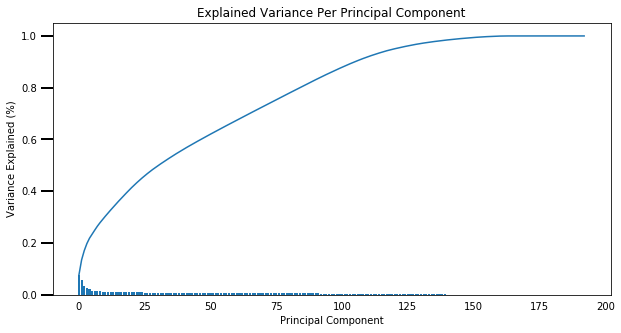

In [94]:
scree_plot(pca2)

In [95]:
# It can be seen from the above plot that when n_components reach near 130, the line flattened. 
# Here, we could achieve the most variance with least n_components
pca3 = PCA(n_components=130)
pca3.fit(azdias_re)
pca3.explained_variance_ratio_.sum()

0.9692242784567804

In [96]:
# Re-apply PCA to the data while selecting for number of components to retain.
azdias_pca = pca3.transform(azdias_re)

### Discussion 2.2: Perform Dimensionality Reduction

Here, from the above plot, when n_components are 130, we could achieve relatively the best result of near 0.97 cumulative explained variance. Therefore, we chose 130 n_components to do PCA to the dataset.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. 
- investigate and interpret feature associations from the first three principal components in this substep. 

In [112]:
len(pca3.components_[0]), len(pca3.components_)

(193, 130)

In [105]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# create an OrderedDict to store each feature name and its relative weight in one component 
from collections import OrderedDict
def weights(pca, i):
    weights_map = {}
    for j, feature in enumerate(azdias_re.columns):
        weights_map[feature] = pca.components_[i-1][j]
    return OrderedDict(sorted(weights_map.items(), key=lambda x: x[1], reverse=True))
    

In [107]:
# First component
weight1 = weights(pca3, 1)
weight1

OrderedDict([('LP_STATUS_GROB_1.0', 0.19711469869610415),
             ('HH_EINKOMMEN_SCORE', 0.18638754943575853),
             ('wealth', 0.1858562182949455),
             ('PLZ8_ANTG3', 0.18134125799820722),
             ('PLZ8_ANTG4', 0.17527927261807333),
             ('ORTSGR_KLS9', 0.1542809641281694),
             ('EWDICHTE', 0.15238834917962646),
             ('FINANZ_HAUSBAUER', 0.1490400682092848),
             ('KBA05_ANTG4', 0.12957415645469023),
             ('LP_STATUS_FEIN_1.0', 0.12614395293056282),
             ('PLZ8_ANTG2', 0.12413431356853444),
             ('FINANZ_SPARER', 0.11992103506580201),
             ('LP_STATUS_FEIN_2.0', 0.11905948132174954),
             ('KBA05_ANTG3', 0.11776489867899513),
             ('FINANZTYP_1.0', 0.11649158624868818),
             ('ANZ_HAUSHALTE_AKTIV', 0.11629076431181262),
             ('CAMEO_DEUG_2015_9', 0.11457055724751172),
             ('ARBEIT', 0.1144118839520965),
             ('RELAT_AB', 0.10720877864026006),
   

#### 1. Top five positive features
- 'HH_EINKOMMEN_SCORE': Estimated household net income 
- 'PLZ8_ANTG3': Number of 3-5 family houses in the PLZ8 region
- 'PLZ8_ANTG4': Number of 10+ family houses in the PLZ8 region
- 'ORTSGR_KLS9': Size of community
- 'EWDICHTE': Density of households per square kilometer

#### 2. Top five negative features
- FINANZ_MINIMALIST: Financial typology - low financial interest
- MOBI_REGIO: Movement patterns
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
- KBA05_GBZ: Number of buildings in the microcell
- KBA05_ANTG1: Number of 1-2 family houses in the microcell

This pc is mainly about household and financial typology.

In [110]:
# Second component
weight2 = weights(pca3, 2)
weight2

OrderedDict([('ALTERSKATEGORIE_GROB', 0.23157489802098596),
             ('FINANZ_VORSORGER', 0.21698376542466682),
             ('ZABEOTYP_3.0', 0.20028633605303375),
             ('SEMIO_ERL', 0.17980098668775918),
             ('SEMIO_LUST', 0.16215536590422272),
             ('RETOURTYP_BK_S', 0.15485908602881815),
             ('W_KEIT_KIND_HH', 0.12309809180044674),
             ('CJT_GESAMTTYP_2.0', 0.10773116137111767),
             ('LP_STATUS_FEIN_1.0', 0.1004371526989097),
             ('FINANZTYP_5.0', 0.09786825318403601),
             ('FINANZ_HAUSBAUER', 0.09109448465933122),
             ('FINANZTYP_2.0', 0.0896893131800468),
             ('FINANZ_MINIMALIST', 0.08317029799181541),
             ('SHOPPER_TYP_3.0', 0.07394316480969605),
             ('SEMIO_KRIT', 0.07362429532556125),
             ('CJT_GESAMTTYP_1.0', 0.07060395028155549),
             ('PLZ8_ANTG3', 0.06938501512442427),
             ('FINANZTYP_6.0', 0.06872857598942358),
             ('PLZ8_ANTG4', 

#### 1. Top five positive features
- 'ALTERSKATEGORIE_GROB': Estimated age based on given name analysis
- 'FINANZ_VORSORGER': Financial typology, for each dimension:be prepared
- 'ZABEOTYP_3.0': Energy consumption typology
- 'SEMIO_ERL': Personality typology - event-oriented
- 'SEMIO_LUST': Personality typology - sensual-minded

#### 2. Top five negative features
- decade: actual decade for people
- FINANZ_SPARER: Financial typology - money-saver
- FINANZ_UNAUFFAELLIGER: Financial typology - inconspicuous
- SEMIO_REL: Personality typology - religious
- SEMIO_TRADV: Personality typology - tradional-minded

This pc is mainly about financial and personality typology, in which positive features of personality typology have more levity and negative features of which represent more conservative attribute.

In [111]:
# Third component
weight3 = weights(pca3, 3)
weight3


OrderedDict([('SEMIO_VERT', 0.31882650578430005),
             ('SEMIO_FAM', 0.2606386432475543),
             ('SEMIO_SOZ', 0.2571200600809525),
             ('SEMIO_KULT', 0.25157812573446764),
             ('FINANZTYP_5.0', 0.13534851154541688),
             ('FINANZ_MINIMALIST', 0.1278787701422367),
             ('SHOPPER_TYP_0.0', 0.12257733235931205),
             ('ZABEOTYP_1.0', 0.11597270396862595),
             ('SEMIO_REL', 0.11326394231826054),
             ('SEMIO_MAT', 0.08971565591158735),
             ('RETOURTYP_BK_S', 0.07479843350635264),
             ('GREEN_AVANTGARDE', 0.07422171080939632),
             ('ORTSGR_KLS9', 0.06417934390633556),
             ('EWDICHTE', 0.0640260330805742),
             ('W_KEIT_KIND_HH', 0.06167475410074576),
             ('SHOPPER_TYP_1.0', 0.054738468446557886),
             ('LP_STATUS_FEIN_10.0', 0.051706943614779725),
             ('LP_STATUS_GROB_5.0', 0.051706943614779725),
             ('ZABEOTYP_6.0', 0.05011031557616931),
 

#### 1. Top five positive features
- SEMIO_VERT: Personality typology - dreamful
- SEMIO_FAM: Personality typology - family-minded
- SEMIO_SOZ: Personality typology - socially-minded
- SEMIO_KULT: Personality typology - cultural-minded
- FINANZTYP_5.0: Most descriptive financial type for individual

#### 2. Top five negative features
- ANREDE_KZ: Gender
- SEMIO_KAEM: Personality typology - combative attitude
- SEMIO_DOM: Personality typology - dominant-minded
- SEMIO_KRIT: Personality typology - critical-minded
- SEMIO_ERL: Personality typology - event-oriented

It seems like that this pc is mainly about personality and financial typology, the fun part is that the top five negative features are also about personality, however which are contrast to the positive features. Such as critical-minded, dominant-minded in contrary to dreamful, cultural-minded and family-minded.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. 
- Perform the above two steps for a number of different cluster counts. We can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data.
- Once we've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. 

In [117]:
# define the function for get different average distance 
# from each point to its assigned cluster's center using different centers.
def get_score(data, center):
    model = KMeans(n_clusters=center)
    model.fit(data)
    score = np.abs(model.score(data))
    return score

In [118]:
# Investigate the change in within-cluster distance across number of clusters.
score = []
centers = list(range(1,31,3))
for i in centers:
    score.append(get_score(azdias_pca, i))

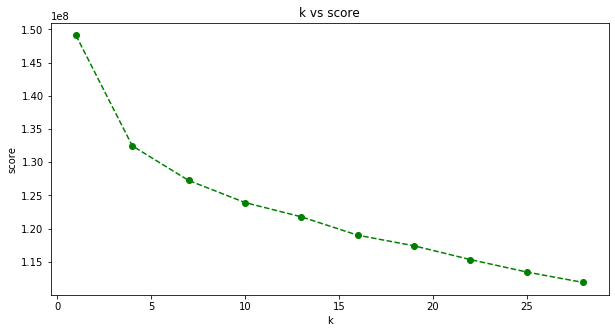

In [123]:
# plot the scree plot of k vs score   
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(centers, score, linestyle='--', marker='o', color='g')
plt.xlabel('k')
plt.ylabel('score')
plt.title('k vs score');

In [124]:
# Re-fit the k-means model with 22 clusters according to the scree plot and obtain
# cluster predictions for the general population demographics data.

model = KMeans(n_clusters=22)
preds = model.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

From the plot above, we can see that the score keeps decreasing, after 22, the change of slope seems to decrease, therefore, I chose 22 as the number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. I'm going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, I will interpret how the general population fits apply to the customer data.

- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function created earlier. 
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. 

In [166]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [167]:
# use clean_data function on this dataset
customers_clean = clean_data(customers)

In [174]:
# recheck shape
customers_clean.shape, azdias_re.shape

((141590, 192), (797077, 193))

In [175]:
# the number of features are different between this two, find out the differences
a = np.array(azdias_re.columns)
b = np.array(customers_clean.columns)
np.setdiff1d(a, b)

array(['GEBAEUDETYP_5.0'], dtype=object)

In [172]:
azdias['GEBAEUDETYP'].value_counts()

1.0    553613
3.0    178668
8.0    152476
2.0      4935
4.0       900
6.0       628
5.0         1
Name: GEBAEUDETYP, dtype: int64

In [173]:
customers['GEBAEUDETYP'].value_counts()

1.0    95145
3.0    23655
8.0    20475
2.0     2057
4.0      251
6.0      142
Name: GEBAEUDETYP, dtype: int64

Why the general population has one more column than the customers is mainly because that, for 'GEBAEUDETYP', in the the general population has the value of 5.0 which customers doest have. Therefore, after one-hot encoding for both of them, the general population would have one more column. Here, i will just add an extra column to the customers to make sure they have the same feature numbers.

In [178]:
customers_clean['GEBAEUDETYP_5.0'] = 0

In [182]:
# recheck shape
customers_clean.shape

(141590, 193)

In [183]:
# fill na with mode
for col in customers_clean.columns:
    customers_clean[col] = customers_clean[col].fillna(customers_clean[col].mode()[0])

In [185]:
# recheck null
customers_clean.isnull().sum(axis=0).value_counts()

0    193
dtype: int64

In [186]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean[customers_clean.columns] = scaler.transform(customers_clean.values)
customers_clean_pca = pca3.transform(customers_clean)
customers_preds = model.predict(customers_clean_pca)

In [194]:
np.unique(customers_preds)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. 

- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select several such cluster and infer what kind of people might be represented by that cluster. Use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.

- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [197]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general = []
customers = []
x = [i+1 for i in range(22)]
for i in range(22):
    general.append((preds==i).sum()/len(preds))
    customers.append((customers_preds==i).sum()/len(customers_preds))
    
df_clusters = pd.DataFrame({'clusters': x, 'general': general, 'customers': customers})

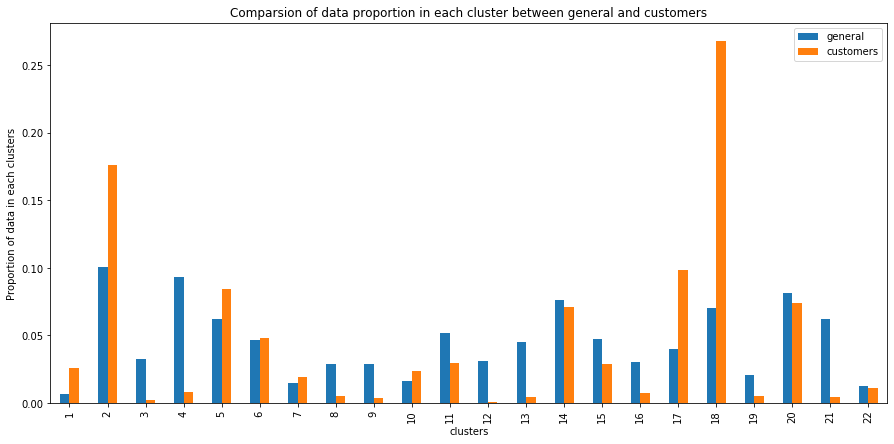

In [230]:
# Comparsion of data proportion in each cluster between general and customers
df_clusters.plot(x='clusters', y=['general', 'customers'], kind='bar', figsize=(15,7))

plt.ylabel('Proportion of data in each clusters')
plt.title('Comparsion of data proportion in each cluster between general and customers');


In [227]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
df_clusters[df_clusters['customers']/df_clusters['general']>2]

,clusters,general,customers
0,1,0.006344,0.026231
16,17,0.040033,0.098164
17,18,0.070637,0.268155


**There are three clusters in which the proportion of customers are more than twice the proportion of general, which suggests those clusters could be the company's target audience.**

In [232]:
data = scaler.inverse_transform(pca3.inverse_transform(customers_clean_pca[
    np.where(customers_preds==1)
])).round()

In [234]:
df1 = pd.DataFrame(data=data, columns=azdias_re.columns)
df1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,-0.0,2.0,...,0.0,0.0,0.0,-0.0,0.0,1.0,3.0,2.0,3.0,2.0
1,1.0,2.0,5.0,1.0,5.0,1.0,1.0,3.0,0.0,3.0,...,0.0,0.0,0.0,-0.0,0.0,1.0,2.0,2.0,3.0,2.0
2,4.0,2.0,5.0,1.0,5.0,2.0,1.0,3.0,0.0,2.0,...,0.0,0.0,0.0,-0.0,-0.0,1.0,2.0,2.0,3.0,2.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,3.0,-1.0,2.0,...,0.0,0.0,0.0,-0.0,0.0,1.0,2.0,3.0,3.0,0.0
4,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,-0.0,1.0,...,-0.0,0.0,0.0,-0.0,0.0,1.0,3.0,2.0,2.0,1.0


In [237]:
df1.decade.mean(), df1.FINANZ_MINIMALIST.mean(), df1.HH_EINKOMMEN_SCORE.mean()

(2.9622195512820513, 4.886418269230769, 3.6209535256410255)

**The data from the cluster 1 suggests that pepole in this cluster born in 40s-50s, with relative high household net income and low financial interest.**

In [238]:
data = scaler.inverse_transform(pca3.inverse_transform(customers_clean_pca[
    np.where(customers_preds==17)
])).round()
df2 = pd.DataFrame(data=data, columns=azdias_re.columns)
df2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,-0.0,1.0,2.0,1.0,4.0,1.0
1,4.0,2.0,5.0,1.0,5.0,1.0,2.0,3.0,0.0,2.0,...,0.0,0.0,0.0,-0.0,0.0,1.0,3.0,2.0,3.0,2.0
2,3.0,1.0,5.0,1.0,6.0,1.0,1.0,3.0,0.0,2.0,...,0.0,0.0,0.0,-0.0,0.0,1.0,2.0,2.0,2.0,1.0
3,4.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,1.0,2.0,1.0,3.0,2.0
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,1.0,3.0,1.0,2.0,2.0


In [239]:
df2.decade.mean(), df2.FINANZ_MINIMALIST.mean(), df2.HH_EINKOMMEN_SCORE.mean()

(2.730852296670881, 4.995232827644332, 2.593578803202697)

**Same features as the former cluster**

In [240]:
data = scaler.inverse_transform(pca3.inverse_transform(customers_clean_pca[
    np.where(customers_preds==18)
])).round()
df3 = pd.DataFrame(data=data, columns=azdias_re.columns)
df3.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,2.0,1.0,4.0,3.0,4.0,2.0,4.0,1.0,1.0,3.0,...,0.0,0.0,0.0,-0.0,-1.0,2.0,5.0,1.0,3.0,2.0
1,1.0,1.0,5.0,2.0,5.0,1.0,3.0,2.0,-1.0,1.0,...,-0.0,-0.0,-0.0,1.0,-1.0,2.0,4.0,3.0,5.0,4.0
2,4.0,2.0,4.0,1.0,5.0,2.0,1.0,3.0,1.0,1.0,...,0.0,0.0,0.0,-0.0,-0.0,1.0,3.0,1.0,2.0,1.0
3,2.0,1.0,4.0,4.0,3.0,3.0,5.0,1.0,-1.0,3.0,...,-0.0,-0.0,-0.0,1.0,-2.0,3.0,6.0,3.0,4.0,2.0
4,3.0,1.0,5.0,1.0,6.0,2.0,1.0,3.0,1.0,3.0,...,0.0,0.0,0.0,-0.0,-0.0,1.0,3.0,1.0,2.0,2.0


In [241]:
df3.decade.mean(), df3.FINANZ_MINIMALIST.mean(), df3.HH_EINKOMMEN_SCORE.mean()

(3.6212765957446806, 4.408510638297872, 3.780141843971631)

**The cluster of 18 also around 50s, more than average household net income and low financial interest**

In [245]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

df_clusters[df_clusters['general']/df_clusters['customers']>2]

,clusters,general,customers
2,3,0.032426,0.002013
3,4,0.093022,0.007967
7,8,0.028628,0.005113
8,9,0.028798,0.003609
11,12,0.030747,0.000946
12,13,0.045436,0.004294
15,16,0.030138,0.007430
18,19,0.020985,0.004979
20,21,0.062284,0.004824


In [248]:
data = scaler.inverse_transform(pca3.inverse_transform(customers_clean_pca[
    np.where(customers_preds==3)
])).round()
df4 = pd.DataFrame(data=data, columns=azdias_re.columns)
df4.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,3.0,2.0,1.0,4.0,4.0,4.0,4.0,3.0,-1.0,2.0,...,-0.0,0.0,0.0,-0.0,-2.0,3.0,6.0,3.0,3.0,0.0
1,2.0,2.0,1.0,4.0,4.0,4.0,4.0,5.0,-1.0,2.0,...,-0.0,-0.0,-0.0,1.0,-0.0,1.0,6.0,3.0,5.0,2.0
2,1.0,2.0,1.0,4.0,5.0,4.0,4.0,4.0,0.0,3.0,...,-0.0,-0.0,-0.0,1.0,-2.0,3.0,5.0,2.0,5.0,3.0
3,1.0,2.0,1.0,4.0,3.0,3.0,5.0,2.0,-0.0,3.0,...,0.0,0.0,0.0,-0.0,-2.0,3.0,5.0,2.0,2.0,3.0
4,3.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,-1.0,2.0,...,-0.0,-0.0,-0.0,-0.0,-2.0,3.0,5.0,3.0,4.0,1.0


In [249]:
df4.decade.mean(), df4.FINANZ_MINIMALIST.mean(), df4.HH_EINKOMMEN_SCORE.mean()

(5.047872340425532, 1.5195035460992907, 5.674645390070922)

**This cluster suggests that the people in this cluster born in around 60s, with very high financial interest and very low household net income.**

In [250]:
data = scaler.inverse_transform(pca3.inverse_transform(customers_clean_pca[
    np.where(customers_preds==4)
])).round()
df5 = pd.DataFrame(data=data, columns=azdias_re.columns)
df5.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,3.0,2.0,3.0,1.0,5.0,1.0,2.0,4.0,-1.0,3.0,...,0.0,0.0,0.0,-0.0,-0.0,1.0,3.0,3.0,3.0,3.0
1,5.0,1.0,4.0,1.0,5.0,0.0,1.0,4.0,0.0,1.0,...,0.0,0.0,0.0,-0.0,-0.0,1.0,2.0,2.0,3.0,2.0
2,4.0,2.0,4.0,0.0,5.0,1.0,2.0,5.0,1.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,1.0,2.0,1.0,3.0,2.0
3,2.0,1.0,4.0,2.0,5.0,0.0,3.0,2.0,-0.0,2.0,...,0.0,0.0,0.0,-0.0,-1.0,2.0,4.0,2.0,5.0,3.0
4,3.0,2.0,2.0,2.0,5.0,2.0,3.0,3.0,1.0,3.0,...,0.0,0.0,0.0,-0.0,-1.0,2.0,4.0,1.0,2.0,2.0


In [255]:
df5.decade.mean(), df5.decade.median(), df5.FINANZ_MINIMALIST.mean(), df5.HH_EINKOMMEN_SCORE.mean()

(2.9401002506265663, 3.0, 3.6979949874686717, 4.773767752715121)

**Around 50s, lower than average financial interest and lower houshold net income**

In [252]:
data = scaler.inverse_transform(pca3.inverse_transform(customers_clean_pca[
    np.where(customers_preds==8)
])).round()
df6 = pd.DataFrame(data=data, columns=azdias_re.columns)
df6.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W,decade,movement,wealth,life_stage
0,2.0,2.0,2.0,2.0,6.0,1.0,1.0,4.0,-1.0,2.0,...,-0.0,1.0,-0.0,1.0,-1.0,2.0,3.0,3.0,5.0,3.0
1,4.0,1.0,3.0,1.0,4.0,1.0,1.0,4.0,-1.0,2.0,...,-0.0,1.0,-0.0,-0.0,0.0,1.0,2.0,3.0,4.0,1.0
2,2.0,2.0,3.0,2.0,5.0,1.0,2.0,5.0,-2.0,2.0,...,-0.0,1.0,-0.0,-0.0,0.0,1.0,3.0,4.0,4.0,1.0
3,3.0,1.0,4.0,2.0,5.0,1.0,3.0,3.0,-1.0,3.0,...,-0.0,1.0,-0.0,-0.0,-1.0,2.0,3.0,3.0,4.0,1.0
4,3.0,1.0,4.0,3.0,5.0,2.0,2.0,2.0,-1.0,3.0,...,-0.0,1.0,-0.0,-0.0,-1.0,2.0,4.0,3.0,4.0,1.0


In [254]:
df6.decade.mean(), df6.decade.median(),  df6.FINANZ_MINIMALIST.mean(), df6.HH_EINKOMMEN_SCORE.mean()

(3.954990215264188, 4.0, 2.898238747553816, 5.996086105675147)

**Around 50s, average financial interest and very low houshold net income**

### Discussion 3.3: Compare Customer Data to Demographics Data
In conlusion, consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population, then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data suggests that group of persons to be outside of the target demographics. 

Therefore, I chose those segements in which the proportion of customers is more than twice the proportion of general to investigate the features of the potential target audience, and also investigate the segments in which the proportion of general is more than twice the proportion of customers to investigat the features of the people which are out of the target. 

It can be roughly inferred that the potential target audience tends to have the features of 
old age, relative high household net income and low financial interest, and people out of the target tend to have the features of middle age, relative high financial interest and very low household net income.